# Using google stock price as data

In [57]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

# Split and process data
2010 - 2020 is training data
2021 is testing data

In [58]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
del train_df['Date']
del train_df['Adj Close']
del test_df['Date']
del test_df['Adj Close']

In [59]:
def normalize(data):
  norm_data = data.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
  return norm_data

In [60]:
def split(df, ref_day = 4, predict_day=1):
    x, y = [], []
    i = 0
    while(i<df.shape[0]-ref_day):
        x.append(np.array(df.iloc[i:i+ref_day]))
        y.append(np.array(df.iloc[i+ref_day:i+ref_day+predict_day]['Close']).tolist())
        i = i+ref_day+predict_day
    return np.array(x), np.array(y)

In [61]:
train_norm = normalize(train_df)
test_norm = normalize(test_df)

In [62]:
train_x,train_y=split(train_norm) #x為第1~4天的股價 y為第5天的收盤價
test_x,test_y=split(test_norm)

In [63]:
print('train shape:',train_x.shape,'\n','train feature:',train_x[0],'\n','train label:',train_y[0])
print('test shape:',test_x.shape,'\n','test feature:',test_x[0],'\n','test label:',test_y[0])

train shape: (553, 4, 5) 
 train feature: [[-0.25397677 -0.25405098 -0.25059085 -0.25344183  0.02539711]
 [-0.25390544 -0.25456231 -0.25142798 -0.25429536  0.09614202]
 [-0.25431482 -0.25516856 -0.25613446 -0.25915989  0.16186021]
 [-0.25941964 -0.26002471 -0.26038519 -0.26353889  0.32619624]] 
 train label: [-0.26108961]
test shape: (41, 4, 5) 
 test feature: [[-0.5395242  -0.56793844 -0.5660692  -0.57925731  0.17214535]
 [-0.56627618 -0.57885755 -0.55769112 -0.56858926 -0.04249904]
 [-0.58466711 -0.57857998 -0.5733634  -0.57332593  0.37078928]
 [-0.55389493 -0.5445944  -0.54200235 -0.52961067  0.27515536]] 
 test label: [-0.51281783]


In [64]:
VAL_RATIO = 0.2

percent = int(train_x.shape[0] * (1 - VAL_RATIO))
train_x, train_y, val_x, val_y = train_x[:percent], train_y[:percent], train_x[percent:], train_y[percent:]

In [65]:
print('train shape:',train_x.shape)
print('val shape:',val_x.shape)

train shape: (442, 4, 5)
val shape: (111, 4, 5)


In [66]:
train_x = train_x.reshape(442,20,1)
val_x = val_x.reshape(111,20,1)
test_x = test_x.reshape(41,20,1)

In [67]:
train_x.shape,train_y.shape

((442, 20, 1), (442, 1))

#Model

In [68]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (train_x.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 20, 50)            10400     
_________________________________________________________________
dropout_12 (Dropout)         (None, 20, 50)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 20, 50)            20200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 20, 50)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 20, 50)            20200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 20, 50)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 50)               

In [69]:
train_history=model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs = 100, batch_size = 16)

Epoch 1/100
28/28 [==============================] - 10s 88ms/step - loss: 0.0090 - val_loss: 0.0260
Epoch 2/100
28/28 [==============================] - 1s 29ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 3/100
28/28 [==============================] - 1s 29ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 4/100
28/28 [==============================] - 1s 29ms/step - loss: 9.0741e-04 - val_loss: 0.0032
Epoch 5/100
28/28 [==============================] - 1s 29ms/step - loss: 9.4849e-04 - val_loss: 0.0015
Epoch 6/100
28/28 [==============================] - 1s 30ms/step - loss: 8.3781e-04 - val_loss: 0.0033
Epoch 7/100
28/28 [==============================] - 1s 29ms/step - loss: 9.2613e-04 - val_loss: 0.0020
Epoch 8/100
28/28 [==============================] - 1s 29ms/step - loss: 8.8316e-04 - val_loss: 0.0016
Epoch 9/100
28/28 [==============================] - 1s 29ms/step - loss: 9.0014e-04 - val_loss: 0.0025
Epoch 10/100
28/28 [==============================] - 1s 29ms/step - loss: 

In [70]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()

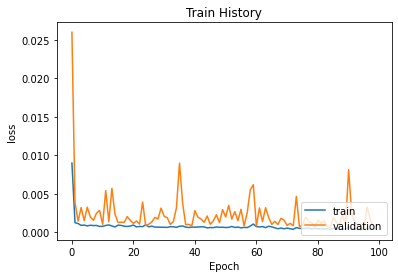

In [71]:
show_train_history(train_history,'loss','val_loss')

#Predict

In [72]:
predict_y = model.predict(test_x)

In [94]:
test_y_denorm = []
pred_denorm = []
for i in range(len(test_y)):
    test_y_denorm.append(test_y[i]*(np.max(test_df['Close'])-np.min(test_df['Close']))+np.mean(test_df['Close']))
    pred_denorm.append(predict_y[i]*(np.max(test_df['Close'])-np.min(test_df['Close']))+np.mean(test_df['Close']))

In [98]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y_denorm,pred_denorm)
print('mse =',mse)

mse = 3948.6814460495284


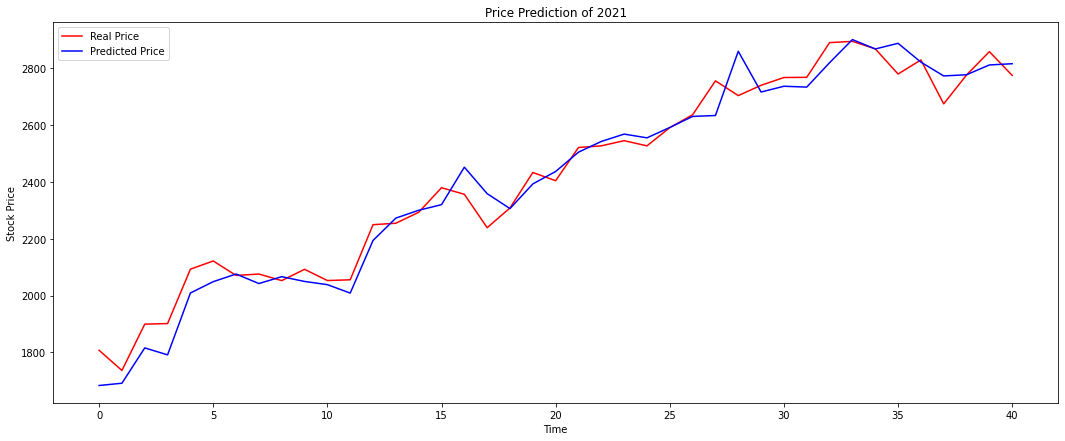

In [97]:
import matplotlib.pyplot as plt 
plt.figure(figsize = (18,7))
plt.plot(test_y_denorm, color = 'red', label = 'Real Price')  # red line is real CLOSE price
plt.plot(pred_denorm, color = 'blue', label = 'Predicted Price')  #blue line is predicted price
plt.title('Price Prediction of 2021')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()